# Metropolis-Hastings algorithm

In this notebook, I will implement Metropolis-Hastings algorithm, a popular example of Markov Chain Monte Carlo sampling method.

In [1]:
import numpy as np
import random 
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 1 Theory

## 1.1 Notation

Let us define notations as follows: 
* $X$ : a set (or more precisely, a measurable space with an appropriate sigma algebra), on which we consider probability distribution 
* $p(x) = \tilde{p}(x)/Z_p$ : the density function of the distribution from which we want to sample, where the constant $Z_p$ can be unknown.
* $q(x|x')$ : proporsal kernel, where $q(x|x')$ stands for the probability density of getting $x$ as a candidate, provided that we have $x'$ now. 

## 1.2 Algorithm

* input : the initial point $x^{ini} \in X$, the number of samples required $N$
* output : the sequence of variables $x^{(0)}, x^{(1)}, \dots x^{(N-1)}$, which (approximately) obey the distribution $p$.
* Given $x^{current}$, generate $x^{tmp}$ according to $q(\cdot | x^{current})$. 
* Set the next state $x^{next}$ as 
$$
\begin{align}
    x^{next} = 
    \begin{cases}
        x^{tmp} & (\mbox{with probability } A(x^{tmp}, x^{current})) \\ 
        x^{current} & (\mbox{with probability } 1 - A(x^{tmp}, x^{current}))
    \end{cases},
\end{align}
$$

where

$$
\begin{align}
    A(x,y) := \min\left( 1, \ \frac{\tilde{p}(x)}{\tilde{p}(y)}\cdot \frac{q(y|x)}{q(x|y)} \right)
\end{align}
$$

# 2 From math to code

We will define `MHsampler` class, which gives us samples according to the algorithm stated in the previous section.

Hereafter,
* we assume $X$ to be $D$ dimensional Euclidean space, and 
* use a $D$ dimensional gaussian distribution with a given covariance matrix $\Sigma$ as the proporsal kernel : 

$$
\begin{align}
    q(x|y) = \frac{1}{(2\pi)^{D/2} \sqrt{\det \Sigma}} \exp\left[ -\frac{1}{2}(x-y)^T \Sigma^{-1} (x-y) \right]
\end{align}
$$

Note that because of the symmetry of the proposal kernel, the algorithm reduces to Metropolis algorithm, and hence we have

$$
\begin{align}
    A(x,y) := \min\left( 1, \ \frac{\tilde{p}(x)}{\tilde{p}(y)} \right)
\end{align}
$$

## 2.1 Properties and methods

We let `MHsampler` class has the following properties and methods

### 2.1.1 Properties

* `D` : $D$. i.e., the dimension of the Euclidean space $X$.
* `sigma` : $\Sigma$, i.e., the covariance matrix of the proporsal kernel
* `p` : $\tilde{p}$, (possibly not normalized) probability density function of the target distribution


### 2.1.2 Methods

* `_A` : $A$, the acceptance probability.
* `sample` : method that returns samples.

## 2.2 Code

In [2]:
class MetropolisSampler:
    def __init__(self, D, sigma, p):
        self.D = D # the dimension of the output space       
        self.sigma = sigma # the covariance matrix of the proporsal kernel
        self.p = p # the density function of the target distribution
    
    def _A(self, x, y):
        '''
        The method which returns the acceptance probability, 
        depending on the current state y and the candidate state x
        
        Parameters
        ----------
        x : 1D numpy array
            1D numpy array representing the candidate state
        y : 1D numpy array
            1D numpy array representing the current state
        Returns 
        ----------
        A : float
            The acceptance probability A(x, y), 
            where y is the current state, and x is the candidate state.
        '''
        denom = self.p(y)  # for avoiding zero division error
        if denom == 0:
            return 1.0
        else:
            return min( 1.0, self.p(x) / denom )
    
    def sample(self, xini, N, stride):
        '''
        The method that performs sampling using Metropolis algorithm, and returns the samples
        
        Parameters
        ----------
        xini : 1D numpy array
            1D numpy array representing the initial point
        N : int
            An integer representing the number of samples required.
        stride : int
            An integer representing how frequent samples are recorded.
            More specifically, we only record sample once in `stride` steps
            
        Returns 
        ----------
        X : 2D array
            (N, self.D) array representing the obtained samples, where X[n] is the n-th sample.
        '''
        X = np.zeros((N, self.D))  # array for recording the sample
        x = xini
        cnt = 0
        for i in range((N-1) * stride + 1):
            xtmp = np.random.multivariate_normal(x, self.sigma)  # sample from the proporsal kernel (gaussian )
            tmprand = random.random()
            if tmprand < self._A(xtmp, x):
                x = xtmp
            if i % stride == 0:
                X[cnt] = x
                cnt += 1
        return X

# 3 Experiments

We consider two exmples, namely, 
* gamma distribution (one dimensional)
* two dimensional gaussian distribution

For these distributions, and compare histograms generated from MCMC samples, and probability density functions.

## 3.1 Gamma distribution (1-D)

$$
\begin{align}
    & p(x) = \frac{1}{\Gamma(k) \theta^k} x^{k-1} e^{-\frac{x}{\theta}} \\
    & \mbox{mean} : k \theta \\
    & \mbox{variance} : k \theta^2
\end{align}
$$


In [3]:
def pgam(x):
    if x > 0:
        return (x**2)*np.exp(-x)
    else:
        return 0.0

sampler = MetropolisSampler(D=1, sigma=np.array([[1.0]]), p=pgam)
samples = sampler.sample(xini=np.array([1.0]), N=5000, stride=10)[:,0]

sample mean : 3.0336510097623117
sample variance : 3.0701027558807716


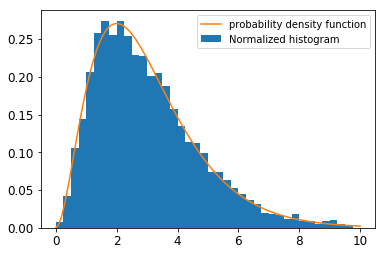

In [4]:
print(f"sample mean : {np.mean(samples)}")
print(f"sample variance : {np.var(samples)}")
step = 0.25
plt.hist(samples, bins=np.arange(0, 10, step), density=True, label="Normalized histogram")
xx = np.linspace(0,10,100)
plt.plot(xx, 0.5*xx**2*np.exp(-xx), label="probability density function")
plt.legend()
plt.show()

### 3.2 Two-dimensional normal distribution

$$
\begin{align}
    & p(x) = \frac{1}{2 \pi \sqrt{\det \Sigma}} \exp\left( -\frac{1}{2} x^T \Sigma^{-1} x \right)  \\
    & \Sigma^{-1} = \begin{pmatrix}
    10 & -6  \\
    -6 & 10
    \end{pmatrix} \\
    & \Sigma = 
    \frac{1}{32}
    \begin{pmatrix}
    5 & 3  \\
    3 & 5
    \end{pmatrix}
    = \begin{pmatrix}
    0.15625 & 0.09375  \\
    0.09375 & 0.15625
    \end{pmatrix}
\end{align}
$$


In [5]:
def p(x):
    precmat = np.array([[10,-6],[-6,10]])
    return np.exp(-0.5*x @ precmat @ x)

sampler = MetropolisSampler(D = 2, sigma = np.array([[1,0],[0,1]]), p = p)
samples = sampler.sample(np.array([1,0]), N=5000, stride=10)

sample mean : [-0.00937263 -0.0029197 ]
sample covariance : [[0.16420045 0.09769379]
 [0.09769379 0.15877392]]


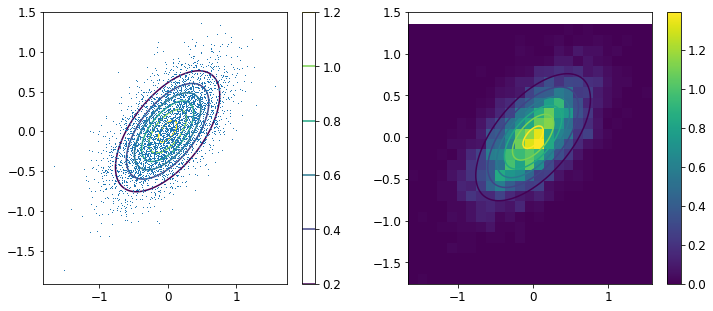

In [6]:
print(f"sample mean : {np.mean(samples, axis=0)}")
print(f"sample covariance : {np.cov(samples, rowvar=False)}")

# two dimensional histogram
H, xx, yy = np.histogram2d(samples[:,0], samples[:,1], bins=25, normed=True)
H = H.T
XX, YY = np.meshgrid(xx, yy)

# contour plot of the density function
xx_f = np.linspace(-1.5,1.5,100)
yy_f = np.linspace(-1.5,1.5,101)
XX_f, YY_f = np.meshgrid(xx_f, yy_f)
Z_f = np.exp( -0.5*( 10*XX_f*XX_f -12*XX_f*YY_f + 10*YY_f*YY_f ))/(2*np.pi)*8

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(samples[:,0], samples[:,1],',')
plt.contour(XX_f,YY_f,Z_f)
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(XX, YY, H)
plt.colorbar()
plt.contour(XX_f,YY_f,Z_f)
plt.show()